# Differentiable Fluid Simulations

** test version, rough... not newest one **

Next, we'll target a more complex example with the Navier-Stokes equations as model. We'll target a 2D case with velocity $\mathbf{u}$, no explicit viscosity term, and a marker density $d$ that drives a simple Boussinesq buoyancy term $\eta d$ adding a force along the y dimension:

$\begin{aligned}
  \frac{\partial u_x}{\partial{t}} + \mathbf{u} \cdot \nabla u_x &= - \frac{1}{\rho} \nabla p 
  \\
  \frac{\partial u_y}{\partial{t}} + \mathbf{u} \cdot \nabla u_y &= - \frac{1}{\rho} \nabla p + \eta d
  \\
  \text{s.t.} \quad \nabla \cdot \mathbf{u} &= 0,
  \\
  \frac{\partial d}{\partial{t}} + \mathbf{u} \cdot \nabla d &= 0 
\end{aligned}$

As optimization objective we'll consider a more difficult variant of the previous example: the state of the observed density $d$ should match a given target after $n=20$ steps of simulation. In contrast to before, the marker $d$ cannot be modified in any way, but only the initial state of the velocity $\mathbf{u}$ at $t=0$. This gives us a split between observable quantities for the loss formulation, and quantities that we can interact with during the optimization (or later on via NNs).

First, let's get the loading of python modules out of the way:

In [1]:
#!pip install --upgrade --quiet phiflow
#!pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow@develop
from phi.flow import *  # The Dash GUI is not supported on Google Colab, ignore the warning
import pylab

/Users/thuerey/Dropbox/mbaDevelSelected/phiflow-v2/phi/physics/_boundaries.py:396: SyntaxWarning: "is" with a literal. Did you mean "=="?
  return self.velocity is 0 and self.angular_velocity is 0
/Users/thuerey/Dropbox/mbaDevelSelected/phiflow-v2/phi/physics/_boundaries.py:396: SyntaxWarning: "is" with a literal. Did you mean "=="?
  return self.velocity is 0 and self.angular_velocity is 0
/Users/thuerey/miniconda3/envs/tf/lib/python3.8/_collections_abc.py:743: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  for key in self._mapping:
/Users/thuerey/miniconda3/envs/tf/lib/python3.8/_collections_abc.py:744: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  yield (key, self._mapping[key])


## Setting up the simulation

To make things a bit more interesting - and to move a bit closer to a NN training process - let's set up of four fluid simulations that run in parallel, i.e. a mini batch similar to DL training. 

While the simulation setup is very similar to before, we'll define an additional batch dimension in addition to the spatial dimensions `x` and `y`. Below, this additional dimension is triggered by inflow tensor, which contains an named `nbatch` dimension, in addition to the spatial ones (the name `batch` is alredy taken). The two `print` statements below illustrate this behavior: they print the tensor shapes with all dimensions, and next only the spatial ones.

TODO xxx **In phiflow we can directly pass a `batch_size=4` parameter to the `Fluid` object. Each fluid simulation is fully independent. In this case they differ by having circular Inflows at different locations.**
TODO ,explain expansion!


In [2]:
domain = Domain(x=32, y=40, boundaries=CLOSED, bounds=Box[0:32, 0:40])

smoke    = domain.scalar_grid(0)  # sampled at cell centers
velocity = domain.staggered_grid(0)  # sampled in staggered form at face centers 

sphere_centers = [(10,5), (12,5), (19,5), (16,5)]
inflow_location = math.tensor(sphere_centers, names='nbatch,vector')
#inflow_location = math.tensor([(4, 5), (8, 5), (12, 5), (16, 5)], names='inflow_loc,vector')
inflow = domain.grid(Sphere(center=inflow_location, radius=3)) * 0.6


#print(f"DEBUG : {velocity.shape.nbatch}")

print(f"Inflow shape: {inflow.shape}")
print(f"Inflow shape, spatial only: {inflow.shape.spatial}")
print(f"Initial velocity shape: {velocity.shape} \n")

# world = World()
# fluid = world.add(Fluid(Domain([40, 32], boundaries=CLOSED), buoyancy_factor=0.05, batch_size=4), physics=IncompressibleFlow())
# centers = [[5,10], [5,12], [5,14], [5,16]]
# world.add(Inflow(Sphere(center=centers, radius=3), rate=0.2));
  #world.step(dt=1.5)
  #for _ in range(20):

for frame in range(20):
  smoke = advect.mac_cormack(smoke, velocity, dt=1) + inflow
  buoyancy_force = smoke * (0, 0.5) >> velocity
  velocity = advect.semi_lagrangian(velocity, velocity, dt=1) + buoyancy_force
  velocity, _, _, _ = fluid.make_incompressible(velocity, domain)
  if frame==0:
    print(f"Velocity shape after 1 step: {velocity.shape}")


Inflow shape: (nbatch=4, x=32, y=40)
Inflow shape, spatial only: (x=32, y=40)
Initial velocity shape: (x=32, y=40, vector=2) 

Velocity shape after 1 step: (nbatch=4, x=32, y=40, vector=2)


**TODO** explain nbatch
phiflow automatically expands dimensions...

Like before, let's plot the marker density after a few steps of simulation (each call to `step()` now updates all four simulations). Note that the boundaries between the four simulations are not visible in the image, but it shows four completely separate density states. The different inflow positions in conjunction with the solid wall boundaries (zero Dirichlet for velocity, and Neumann for pressure), result in four  different end states of the simulation.

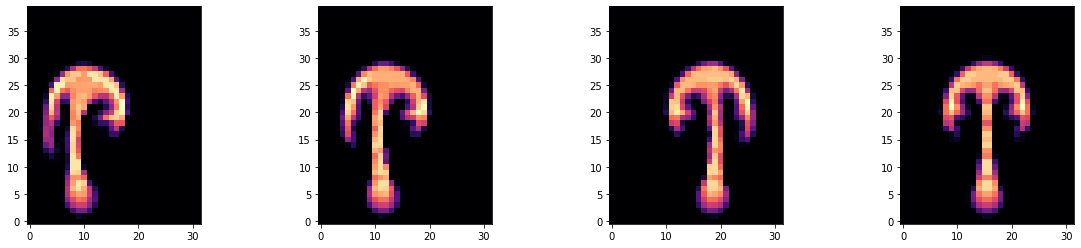

In [3]:
#pylab.imshow(np.concatenate(fluid.density.data[...,0], axis=1), origin='lower', cmap='magma')
fig, axes = pylab.subplots(1, 4, figsize=(20, 4))
for i in range(inflow.shape.nbatch):
  axes[i].imshow(smoke.values.nbatch[i].numpy('y,x'), origin='lower', cmap='magma')

**TODO** add labels...

Now we see four simulations, (0) to (3). This final density of simulation (0), with the curved plume on the far left, will be our **reference state**, while the initial velocity of the other three will be modified in the optimization procedure below.

## Differentiation

The simulation we just computed was using purely (non-differentiable) operations from numpy.
To enable differentiability, we need to build a TensorFlow graph that computes this result. 

This can be achieved by changing the import statement to [`from phi.tf.flow import *`](https://tum-pbs.github.io/PhiFlow/phi/tf/flow.html) (or [`phi.torch.flow`](https://tum-pbs.github.io/PhiFlow/phi/torch/flow.html) for PyTorch).
Tensors created after this import will be allocated using TensorFlow and operations on these will be executed with TensorFlow.
Note that this will make use of a GPU through CUDA if your TensorFlow version supports it, and potentially custom CUDA operators of phiflow (if you dont have those compiled you might see a warning below, which you can safely ignore).

In [4]:
from phi.tf.flow import *  # Causes deprecation warnings with TF 1.15
import pylab
# ### session = Session(None)  # Used to run the TensorFlow graph

Could not load resample cuda libraries: CUDA binaries not found at /Users/thuerey/Dropbox/mbaDevelSelected/phiflow-v2/phi/tf/cuda/build/resample.so. Run "python setup.py tf_cuda" to compile them


Now that we have imported `phi.tf.flow`, let's set up the simulation just like before. But now, the initial velocity state that we start from will be a variable quantity that we can modify. Then we can optimize these initial velocities so that all simulations arrive at a final state that is similar to the first simulation from the previous example. I.e., the state shown in the left-most image above.

This is a fairly tough task: we're producing diffent dynamics by changing the boundary conditions (the marker inflow position), and an optimizer should now find a single initial velocity state, that gives the same state as simulation `0` above at $t=20$. Thus, after 20 steps the simulation should reproduce a different set of boundary conditions from the velocity state. It would be much easier to simply change the position of the marker inflow to arrive at this goal, but -- to make things a bit more difficult and interesting here -- the inflow is _not_ a degree of freedom. The optimizer can only change the velocity $\mathbf{u}$ at time $t=0$.

To achieve this, we'll run the full chain of steps for the simulation over time in TensorFlow, and track the gradients for the initial velocity state at $t=0$ to be modified in the optimization.

**REMOVE we create a TensorFlow variable for the velocity at t=0.
It is initialized with zeros (like with the NumPy simulation above) and can later be used as a target for optimization.**

In [5]:
domain = Domain(x=32, y=40, boundaries=CLOSED, bounds=Box[0:32, 0:40])
sphere_centers = [(10.,5.), (12.,5.), (19.,5.), (16.,5.)]
inflow_location = math.tensor(sphere_centers, names='inflow_loc,vector', convert=True)
inflow = domain.grid(Sphere(center=inflow_location, radius=3)) * 0.6

# world = World()
# fluid = world.add(Fluid(Domain([40, 32], boundaries=CLOSED), buoyancy_factor=0.05, batch_size=4), physics=IncompressibleFlow())
# world.add(Inflow(Sphere(center=centers, radius=3), rate=0.2));
# fluid.velocity = variable(fluid.velocity)  # create TensorFlow variable
# initial_state = fluid.state  # Remember the state at t=0 for later visualization
# session.initialize_variables()

We can verify that tensors are now backed by TensorFlow with the following `print` statement.

In [6]:
type(inflow.values.native())

tensorflow.python.framework.ops.EagerTensor

Note that tensors created with NumPy will keep on using NumPy/SciPy operations unless a TensorFlow tensor is also passed to the same operation.

**CONTINUE**

The simulation now contains variables in the initial state.
Since all later states depend on the value of the variable, the `step` method cannot directly compute concrete state values.
Instead, `world.step` will extend the TensorFlow graph by the operations needed to perform the step.

To execute the graph with actual data, we can use `session.run`, just like with regular TensorFlow 1.x. While `run` would usually be used to infer predictions from a learning model, it now executes the graph of simulation steps.

In [7]:
world.step()
pylab.imshow(np.concatenate(session.run(fluid.density).data[...,0], axis=1), origin='lower', cmap='magma')

NameError: name 'world' is not defined

Let's build a graph for the full simulation.

In [ ]:
for step in range(20):
  print('Building graph for time step %d' % step)
  world.step(dt=1.5)

When calling `session.run` now, the full simulation is evaluated using TensorFlow operations.
This will take advantage of your GPU, if available.
If you compile Φ<sub>Flow</sub> with [CUDA support](https://github.com/tum-pbs/PhiFlow/blob/master/documentation/Installation_Instructions.md), the TensorFlow graph will also use optimized operators for efficient simulation and training runs.

The `session.run()` call of the following code block will now retrieve the final fluid density, and for that it actually needs to process all 20 simulation steps of the TF graph that we just constructed.

In [ ]:
print('Computing frames...')
original_state = np.concatenate(session.run(fluid.density).data[...,0], axis=1)
pylab.imshow(original_state, origin='lower', cmap='magma')

Next, we define the *loss* function. This is the value we want to decrease via optimization.
For this example, we want the marker densities of all final simulation states to match the left-most one, called `target`, in terms of an $L^2$ norm.

For the optimizer, we choose again gradient descent for this example.

In [ ]:
target = session.run(fluid.density).data[0,...]
loss = math.l2_loss(fluid.density.data[1:,...] - target)
optim = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
session.initialize_variables()

print('Initial loss: %f' % session.run(loss))

With the loss and optimizer set up, all that's left is to run the actual optimization.

In [ ]:
for optim_step in range(100):
    _, loss_value = session.run([optim, loss])
    if optim_step<3 or optim_step%10==0: 
        print('Optimization step %d, loss %f %s' % (optim_step, loss_value, '' if optim_step else '. The first step sets up the adjoint graph.'))


The loss should have gone down significantly, from above 60 to below 40, and now we can visualize how well the reconstruction for the last frame turned out for simulations 1 to 3.

In [ ]:
optimized_state = np.concatenate(session.run(fluid.density).data[...,0], axis=1)
pylab.title("Original state at t=20 (top), and optimized version (bottom):")
pylab.imshow( np.concatenate([optimized_state, original_state],axis=0), origin='lower', cmap='magma')

Naturally, the image on the left is the same (this is simulation (0), our reference), and the other three simulations now exhibit a noticeable curved shape towards the left. This is especially visible for the far right simulation (3), which was moving straight up in its original state, and now has an off-center plume shape that tries to match the reference on the left. 

Note that this simulation (like both others) needs to "work" with a fixed inflow, hence it cannot simply "produce" marker density out of the blue to match the target. Also it needs to take into account how the non-linear model equations change the state of the system over the course of 20 time steps. So the optimization goal is quite tough, and it is not possible to exactly satisfy the constraints to match simulation (0) in this scenario. This is exactly what makes it an interesting test case, though.

Now we can also have a look at the now-optimized initial velocity field. Here we see the y-components (from `data[...,0]`).

In [ ]:
optimized_velocity_field = session.run(initial_state.velocity).at_centers()

pylab.title('Initial y-velocity (optimized)')
pylab.imshow(np.concatenate(optimized_velocity_field.data[...,0], axis=1), origin='lower')

This nicely shows how the initial perturbation of the velocity field grows for the larger inflow deviations towards the right:

For comlpeteness, here are the x-components:

In [ ]:
pylab.title('Initial x-velocity (optimized)')
pylab.imshow(np.concatenate(optimized_velocity_field.data[...,1], axis=1), origin='lower')

This example illustrates how the differentiable physics approach can easily be extended towards significanlty more complex PDEs. Above, we've optimized for a mini-batch of 20 steps of a full Navier-Stokes solver.

This is a powerful basis to bring NNs into the picture! As you might have noticed, our degrees of freedom were still a regular grid, and we've solved a single inverse problem. There was more than one case to solve, but nonetheless no question of generalization and no neural network structure.